In [1]:
import sys
from aubio import source, pitch
import os
import numpy as np

In [2]:
win_s = 512
hop_s = 128 
samplerate = 44100

# get the input file
dir = os.path.dirname(os.getcwd())
#WAV_FILE = dir+'/AudioProcessing/audios/record-672279722.51811.wav'
WAV_FILE = dir+'/AudioProcessing/audios/record-667269360.9571331.wav'
s = source(WAV_FILE, samplerate, hop_s)
samplerate = s.samplerate

tolerance = 0.8

pitch_o = pitch("yin", win_s, hop_s, samplerate)
pitch_o.set_unit("midi")
pitch_o.set_tolerance(tolerance)

pitches = []
confidences = []

total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    #pitch = int(round(pitch))
    confidence = pitch_o.get_confidence()
    #if confidence < 0.8: pitch = 0.
    #print("%f %f %f" % (total_frames / float(samplerate), pitch, confidence))
    pitches += [pitch]
    confidences += [confidence]
    total_frames += read
    if read < hop_s: break

In [3]:
import sys
from aubio import source
from numpy import zeros, hstack

def get_waveform_plot(filename, samplerate = 0, block_size = 4096, ax = None, downsample = 2**4):
    import matplotlib.pyplot as plt
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    hop_s = block_size

    allsamples_max = zeros(0,)
    downsample = downsample  # to plot n samples / hop_s

    a = source(filename, samplerate, hop_s)            # source file
    if samplerate == 0: samplerate = a.samplerate

    total_frames = 0
    while True:
        samples, read = a()
        # keep some data to plot it later
        new_maxes = (abs(samples.reshape(hop_s//downsample, downsample))).max(axis=0)
        allsamples_max = hstack([allsamples_max, new_maxes])
        total_frames += read
        if read < hop_s: break
    allsamples_max = (allsamples_max > 0) * allsamples_max
    allsamples_max_times = [ ( float (t) / downsample ) * hop_s for t in range(len(allsamples_max)) ]

    ax.plot(allsamples_max_times,  allsamples_max, '-b')
    ax.plot(allsamples_max_times, -allsamples_max, '-b')
    ax.axis(xmin = allsamples_max_times[0], xmax = allsamples_max_times[-1])

    set_xlabels_sample2time(ax, allsamples_max_times[-1], samplerate)
    return ax

def set_xlabels_sample2time(ax, latest_sample, samplerate):
    ax.axis(xmin = 0, xmax = latest_sample)
    if latest_sample / float(samplerate) > 60:
        ax.set_xlabel('time (mm:ss)')
        ax.set_xticklabels([ "%02d:%02d" % (t/float(samplerate)/60, (t/float(samplerate))%60) for t in ax.get_xticks()[:-1]], rotation = 50)
    else:
        ax.set_xlabel('time (ss.mm)')
        ax.set_xticklabels([ "%02d.%02d" % (t/float(samplerate), 100*((t/float(samplerate))%1) ) for t in ax.get_xticks()[:-1]], rotation = 50)


# if __name__ == '__main__':
#     import matplotlib.pyplot as plt
#     if len(sys.argv) < 2:
#         print("Usage: %s <filename>" % sys.argv[0])
#     else:
#         for soundfile in sys.argv[1:]:
#             get_waveform_plot(soundfile)
#             # display graph
#             plt.show()

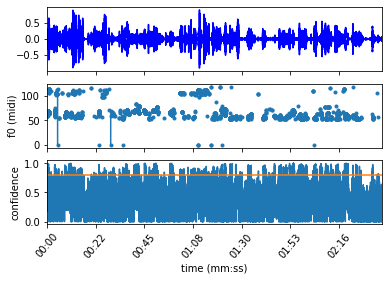

In [6]:
#print pitches
import os.path
from numpy import array, ma
import matplotlib.pyplot as plt

skip = 1

pitches = array(pitches[skip:])
confidences = array(confidences[skip:])
times = [t * hop_s for t in range(len(pitches))]

fig = plt.figure()

ax1 = fig.add_subplot(311)
ax1 = get_waveform_plot(WAV_FILE, samplerate = samplerate, block_size = hop_s, ax = ax1)
plt.setp(ax1.get_xticklabels(), visible = False)
ax1.set_xlabel('')

def array_from_text_file(filename, dtype = 'float'):
    filename = os.path.join(os.path.dirname(__file__), filename)
    return array([line.split() for line in open(filename).readlines()],
        dtype = dtype)

ax2 = fig.add_subplot(312, sharex = ax1)
ground_truth = os.path.splitext(WAV_FILE)[0] + '.f0.Corrected'
if os.path.isfile(ground_truth):
    ground_truth = array_from_text_file(ground_truth)
    true_freqs = ground_truth[:,2]
    true_freqs = ma.masked_where(true_freqs < 2, true_freqs)
    true_times = float(samplerate) * ground_truth[:,0]
    ax2.plot(true_times, true_freqs, 'r')
    ax2.axis( ymin = 0.9 * true_freqs.min(), ymax = 1.1 * true_freqs.max() )
# plot raw pitches
#ax2.plot(times, pitches, '.g')
# plot cleaned up pitches
cleaned_pitches = pitches
#cleaned_pitches = ma.masked_where(cleaned_pitches < 0, cleaned_pitches)
#cleaned_pitches = ma.masked_where(cleaned_pitches > 120, cleaned_pitches)
cleaned_pitches = ma.masked_where(confidences < tolerance, cleaned_pitches)
ax2.plot(times, cleaned_pitches, '.-')
#ax2.axis( ymin = 0.9 * cleaned_pitches.min(), ymax = 1.1 * cleaned_pitches.max() )
#ax2.axis( ymin = 55, ymax = 70 )
plt.setp(ax2.get_xticklabels(), visible = False)
ax2.set_ylabel('f0 (midi)')

# plot confidence
ax3 = fig.add_subplot(313, sharex = ax1)
# plot the confidence
ax3.plot(times, confidences)
# draw a line at tolerance
ax3.plot(times, [tolerance]*len(confidences))
ax3.axis(xmin = times[0], xmax = times[-1])
ax3.set_ylabel('confidence')
set_xlabels_sample2time(ax3, times[-1], samplerate)
plt.show()
#plt.savefig(os.path.basename(filename) + '.svg')

In [7]:
import parselmouth

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set() # Use seaborn's default style to make attractive graphs

# Plot nice figures using Python's "standard" matplotlib library
snd = parselmouth.Sound("docs/examples/audio/the_north_wind_and_the_sun.wav")
plt.figure()
plt.plot(snd.xs(), snd.values.T)
plt.xlim([snd.xmin, snd.xmax])
plt.xlabel("time [s]")
plt.ylabel("amplitude")
plt.show() # or plt.savefig("sound.png"), or plt.savefig("sound.pdf")

ModuleNotFoundError: No module named 'parselmouth'